# Part 1

## import libraries

In [644]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [645]:
import warnings 
warnings.filterwarnings('ignore')

In [646]:
df = pd.read_csv('Q1_data.csv')

In [647]:
df.head(5)

,Unnamed: 0,symbol,name,time_stamp,time_high,time_low,open,close,high,low,market_cap,volume
0,0,BTC,Bitcoin,2023-05-17T23:59:59.999Z,2023-05-17T20:09:00.000Z,2023-05-17T14:03:00.000Z,27035.470130,27398.802028,27465.927904,26600.144844,5.308901e+11,1.514001e+10
1,1,BTC,Bitcoin,2023-05-13T23:59:59.999Z,2023-05-13T18:50:00.000Z,2023-05-13T00:32:00.000Z,26807.769044,26784.078561,27030.482960,26710.873803,5.188737e+11,9.999172e+09
2,2,BTC,Bitcoin,2023-03-08T23:59:59.999Z,2023-03-08T00:23:00.000Z,2023-03-08T23:43:00.000Z,22216.442321,21718.079830,22268.896252,21708.050506,4.194214e+11,2.253658e+10
3,3,BTC,Bitcoin,2023-02-21T23:59:59.999Z,2023-02-21T08:30:00.000Z,2023-02-21T22:06:00.000Z,24833.048914,24436.354485,25126.851686,24200.364116,4.715777e+11,3.125210e+10
4,4,BTC,Bitcoin,2022-10-15T23:59:59.999Z,2022-10-15T03:59:00.000Z,2022-10-15T23:04:00.000Z,19185.437304,19067.635082,19212.541608,19019.250125,3.657224e+11,1.619224e+10


In [648]:
df['name'].unique()

array(['Bitcoin', 'BNB', 'Ethereum', 'Tether USDt'], dtype=object)

## Normalization Using StandardScaler

In [649]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df_mm = df.copy()
df[['volume','market_cap']] = scaler.fit_transform(df[['volume','market_cap']])

Text(0, 0.5, 'Market Cap')

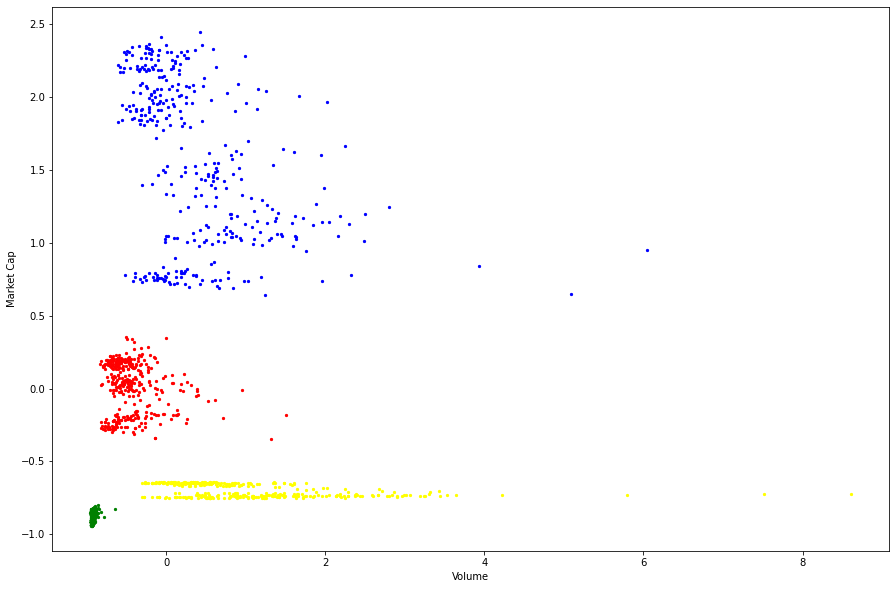

In [650]:
plt.figure(figsize=(15, 10))
plt.scatter(df[df['name'] == 'Bitcoin']['volume'], df[df['name'] == 'Bitcoin']['market_cap'], s=5, color='blue')
plt.scatter(df[df['name'] == 'BNB']['volume'], df[df['name'] == 'BNB']['market_cap'], s=5, color='green')
plt.scatter(df[df['name'] == 'Ethereum']['volume'], df[df['name'] == 'Ethereum']['market_cap'], s=5, color='red')
plt.scatter(df[df['name'] == 'Tether USDt']['volume'], df[df['name'] == 'Tether USDt']['market_cap'], s=5, color='yellow')
plt.xlabel('Volume')
plt.ylabel('Market Cap')

## 1-1 : KMeans Clustering

In [1090]:
#run kmeans clustering based on market cap and volume 
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=5 , n_init=100 )
kmeans.fit(df[['market_cap', 'volume']])
df['cluster'] = kmeans.predict(df[['market_cap', 'volume']])

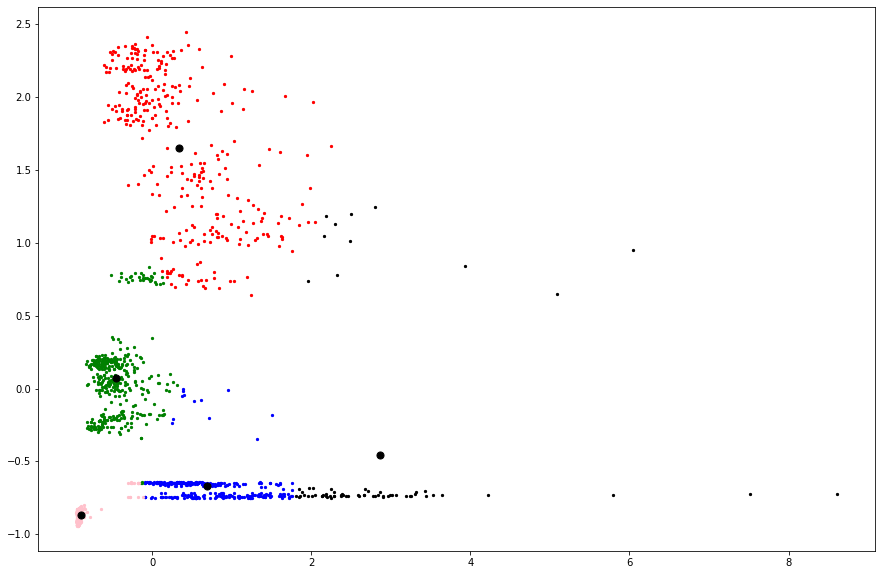

In [1093]:
#plot the clusters
plt.figure(figsize=(15, 10))
plt.scatter(df[df['cluster'] == 0]['volume'], df[df['cluster'] == 0]['market_cap'], s=5, color='blue')
plt.scatter(df[df['cluster'] == 1]['volume'], df[df['cluster'] == 1]['market_cap'], s=5, color='green')
plt.scatter(df[df['cluster'] == 2]['volume'], df[df['cluster'] == 2]['market_cap'], s=5, color='red')
plt.scatter(df[df['cluster'] == 3]['volume'], df[df['cluster'] == 3]['market_cap'], s=5, color='pink')
plt.scatter(df[df['cluster'] == 4]['volume'], df[df['cluster'] == 4]['market_cap'], s=5, color='black')
plt.scatter(kmeans.cluster_centers_[:, 1], kmeans.cluster_centers_[:, 0], color='black', marker='o', s=50)
plt.show()

## 1-2 Finding Optimal K

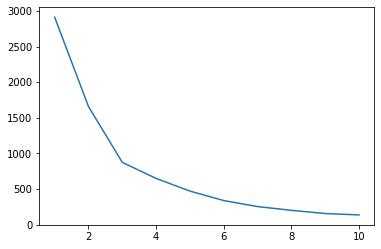

In [690]:
#run this for k =1 to k = 10 and calculate within cluster sum of squares
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(df[['market_cap', 'volume']])
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 11), wcss)

as you can see, elbow method can't help because of the shape of the graph. so we use silhouette method instead.

In [1094]:
#6 & 10 

In [732]:
from sklearn.metrics import silhouette_score
K_range = range(2, 13)
silhouette_scores = []

for K in K_range:
    kmeans = KMeans(n_clusters=K)
    cluster_labels = kmeans.fit_predict(df_mm[['market_cap', 'volume']])
    silhouette_avg = silhouette_score(df_mm[['market_cap', 'volume']], cluster_labels)
    silhouette_scores.append(silhouette_avg)

optimal_K = K_range[silhouette_scores.index(max(silhouette_scores))]

print("Optimal K: ", optimal_K)

Optimal K:  6


Testing davies_bouldin_score

2 & 8 

In [731]:
from sklearn.metrics import davies_bouldin_score
K_range = range(2, 11)
dbi_scores = []

for K in K_range:
    kmeans = KMeans(n_clusters=K)
    cluster_labels = kmeans.fit_predict(df_mm[['market_cap', 'volume']])
    dbi = davies_bouldin_score(df_mm[['market_cap', 'volume']], cluster_labels)
    dbi_scores.append(dbi)

# Find the K with the lowest Davies-Bouldin Index
optimal_K = K_range[np.argmin(dbi_scores)]
min_dbi = min(dbi_scores)
print(f"Optimal K according to Davies-Bouldin Index: {optimal_K}")
# print(f"Minimum Davies-Bouldin Index: {min_dbi}")

Optimal K according to Davies-Bouldin Index: 2


Testing GaussianMixture

In [725]:
from sklearn.mixture import GaussianMixture
K_range = range(2, 11)
bic_scores = []

for K in K_range:
    gmm = GaussianMixture(n_components=K)
    gmm.fit(df_mm[['market_cap', 'volume']])
    bic = gmm.bic(df_mm[['market_cap', 'volume']])
    bic_scores.append(bic)

# Find the K with the lowest BIC score
optimal_K = K_range[np.argmin(bic_scores)]
min_bic = min(bic_scores)

print(f"Optimal K according to BIC: {optimal_K}")

Optimal K according to BIC: 8


<font color="red">TODO ^  Which one should we choose</font>


## 1-3 : Clustering with DBSCAN

### Normalization Using MinMaxScaler

In [655]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df_mm[['volume','market_cap']] = scaler.fit_transform(df[['volume','market_cap']])

In [656]:
# dbscan = DBSCAN(eps=0.04, min_samples=15, metric='correlation')
# {'euclidean', 'precomputed', 'correlation', 'rogerstanimoto', 'canberra', 'sqeuclidean', 'nan_euclidean',
# 'seuclidean', 'wminkowski', 'sokalmichener', 'hamming', 'l1', 'russellrao', 'chebyshev', 
# 'cosine', 'sokalsneath', 'minkowski', 'cityblock', 'mahalanobis', 'manhattan', 'jaccard', 'haversine', 'kulsinski', 
# 'dice', 'yule', 'l2', 'matching', 'braycurtis'}

#dbscan = DBSCAN(eps=0.0366482344, min_samples=5, metric='chebyshev')


In [1029]:
#run dbscan clustering based on market cap and volume
from sklearn.cluster import DBSCAN
dbscan = DBSCAN(eps=0.040, min_samples=5)
dbscan.fit(df_mm[['market_cap', 'volume']])
df_mm['cluster'] = dbscan.labels_
print(df_mm['cluster'].unique())
print((df_mm['cluster'] == -1).sum())

[ 0  1  2  3  4 -1]
21


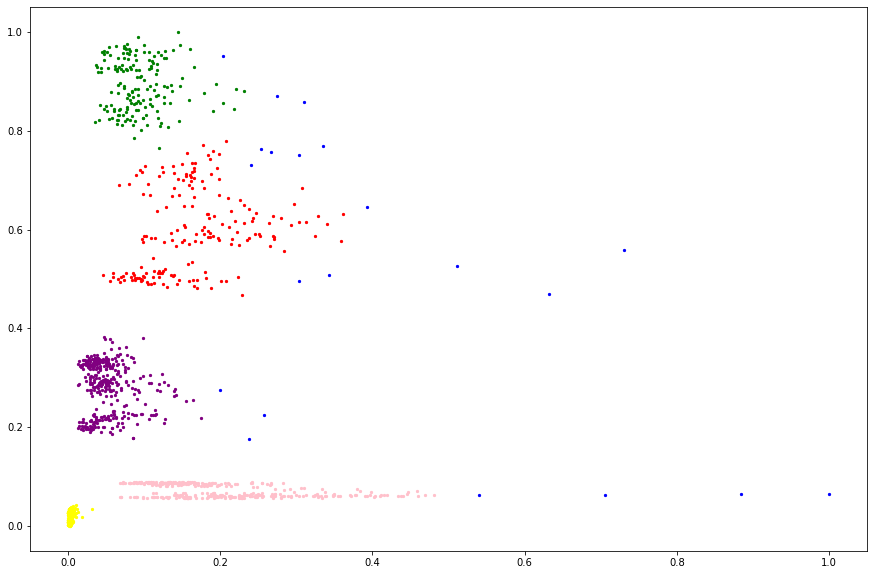

In [1030]:
#plot the clusters
plt.figure(figsize=(15, 10))
plt.scatter(df_mm[df_mm['cluster'] == -1]['volume'], df_mm[df_mm['cluster'] == -1]['market_cap'], s=5, color='blue')
plt.scatter(df_mm[df_mm['cluster'] == 0]['volume'], df_mm[df_mm['cluster'] == 0]['market_cap'], s=5, color='green')
plt.scatter(df_mm[df_mm['cluster'] == 1]['volume'], df_mm[df_mm['cluster'] == 1]['market_cap'], s=5, color='red')
plt.scatter(df_mm[df_mm['cluster'] == 2]['volume'], df_mm[df_mm['cluster'] == 2]['market_cap'], s=5, color='yellow')
plt.scatter(df_mm[df_mm['cluster'] == 3]['volume'], df_mm[df_mm['cluster'] == 3]['market_cap'], s=5, color='purple')
plt.scatter(df_mm[df_mm['cluster'] == 4]['volume'], df_mm[df_mm['cluster'] == 4]['market_cap'], s=5, color='pink')
# plt.scatter(df_mm[df_mm['cluster'] == 5]['volume'], df_mm[df_mm['cluster'] == 5]['market_cap'], s=5, color='black')


## Even better 

### (By using `0.041` as `eps`)

In [1037]:
#run dbscan clustering based on market cap and volume
from sklearn.cluster import DBSCAN
dbscan = DBSCAN(eps=0.041, min_samples=5)
dbscan.fit(df_mm[['market_cap', 'volume']])
df_mm['cluster'] = dbscan.labels_
df_mm['cluster'].unique()
print(df_mm['cluster'].unique())
print((df_mm['cluster'] == -1).sum())

[ 0  1  2  3 -1]
20


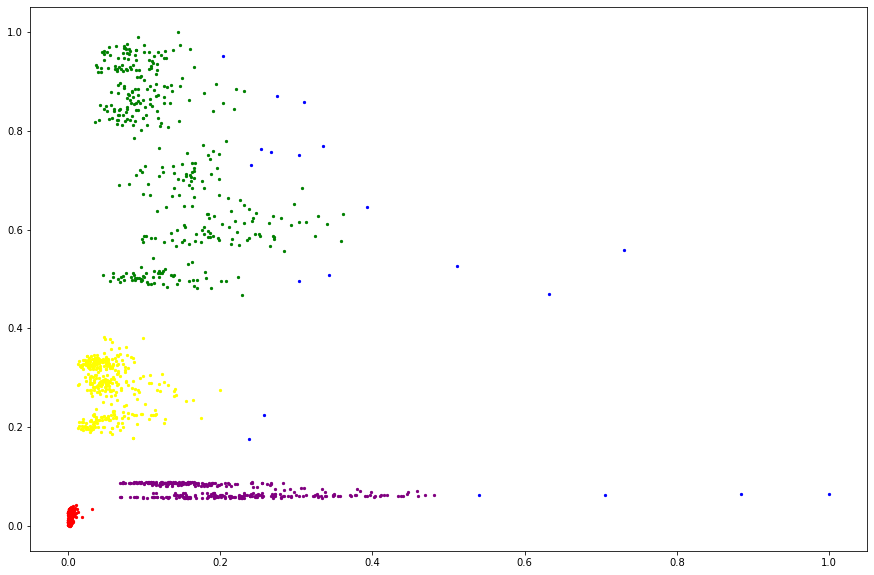

In [1038]:
#plot the clusters
plt.figure(figsize=(15, 10))
plt.scatter(df_mm[df_mm['cluster'] == -1]['volume'], df_mm[df_mm['cluster'] == -1]['market_cap'], s=5, color='blue')
plt.scatter(df_mm[df_mm['cluster'] == 0]['volume'], df_mm[df_mm['cluster'] == 0]['market_cap'], s=5, color='green')
plt.scatter(df_mm[df_mm['cluster'] == 1]['volume'], df_mm[df_mm['cluster'] == 1]['market_cap'], s=5, color='red')
plt.scatter(df_mm[df_mm['cluster'] == 2]['volume'], df_mm[df_mm['cluster'] == 2]['market_cap'], s=5, color='yellow')
plt.scatter(df_mm[df_mm['cluster'] == 3]['volume'], df_mm[df_mm['cluster'] == 3]['market_cap'], s=5, color='purple')
plt.scatter(df_mm[df_mm['cluster'] == 4]['volume'], df_mm[df_mm['cluster'] == 4]['market_cap'], s=5, color='pink')


<font color="red">TO Know ^  Why this Works . </font>


# Part 2

In [1109]:
df2 = pd.read_csv('coins_data.xlsx - Sheet1.csv')

In [1110]:
df2.head(5)

,Symbol,Volume,MarketCap,TotalSupply,ProofType,Network
0,LEO,1.823284e+06,3586504072,"985,239,504",PoS,Ethereum
1,UNI,9.918768e+07,3992451215,"1,000,000,000",PoS,Ethereum
2,WBTC,1.415410e+08,4237575489,"163,106",PoW,Ethereum
3,AVAX,2.197065e+08,4901630273,"431,804,080",PoS,Avalanche
4,DAI,2.177113e+08,5513660644,"5,347,888,596",stablecoin,Ethereum


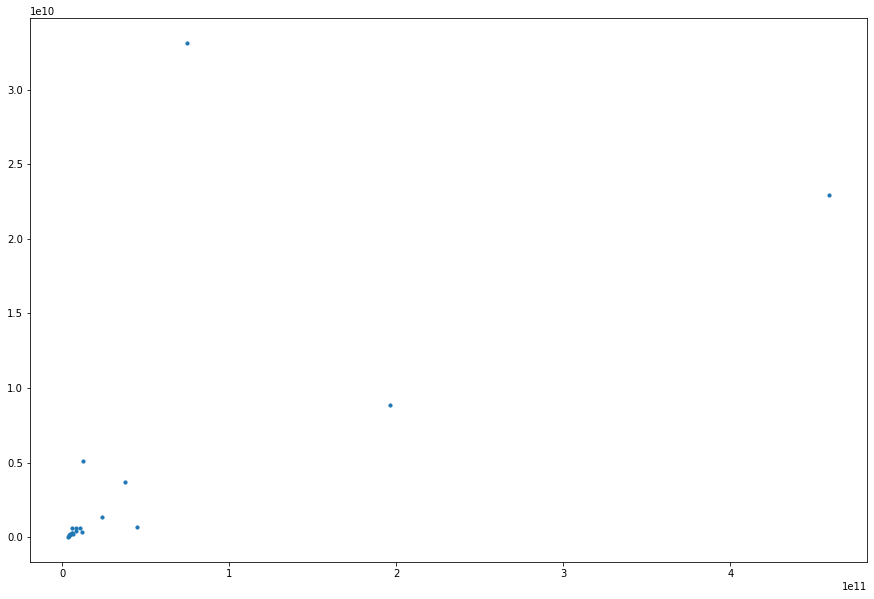

In [1111]:
plt.figure(figsize=(15, 10))
plt.scatter(df2['MarketCap'], df2['Volume'] , s=10)

### 2-1 : Hierarchical Clustering

### Normalization Using StandardScaler

In [1112]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df2[['Volume','MarketCap']] = scaler.fit_transform(df2[['Volume','MarketCap']])

### Calculating the linkage matrix

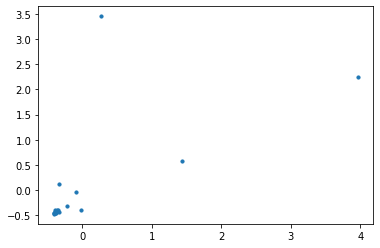

In [1113]:
import numpy as np
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
import matplotlib.pyplot as plt

# pairwise distances between data points
distances = pdist(df2[['MarketCap', 'Volume']], metric='euclidean')
square_distances = squareform(distances)
plt.scatter(df2['MarketCap'], df2['Volume'] , s=10 )

In [1114]:
condensed_distances = squareform(square_distances)
linkage_matrix = linkage(condensed_distances, method='average')

### Plotting the dendrogram

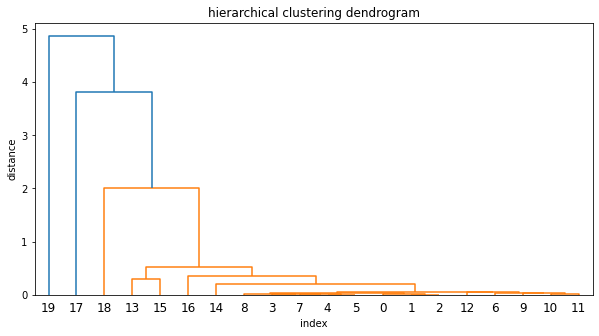

In [1115]:
plt.figure(figsize=(10, 5))
dendrogram(linkage_matrix, labels=df2.index)
plt.xlabel('index')
plt.ylabel('distance')
plt.title('hierarchical clustering dendrogram')
plt.show()

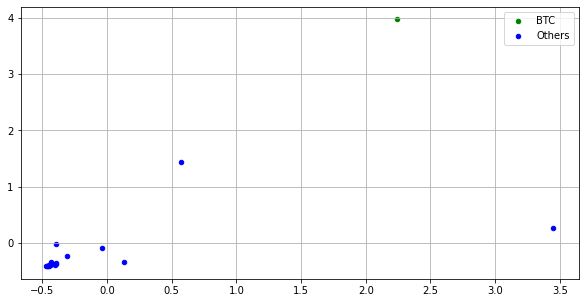

In [1116]:
cluster_assignments = fcluster(linkage_matrix, t=4, criterion='distance')
# print(cluster_assignments)
df2['Cluster'] = cluster_assignments
#plot the clusters
plt.figure(figsize=(10, 5))
plt.scatter(df2[df2['Cluster'] == 2]['Volume'], df2[df2['Cluster'] == 2]['MarketCap'], s=20, color='green' , label=df2.iloc[-1]['Symbol'])
plt.scatter(df2[df2['Cluster'] == 1]['Volume'], df2[df2['Cluster'] == 1]['MarketCap'], s=20, color='blue' , label='Others')
plt.grid(True)
plt.legend()
df2.drop('Cluster' , axis=1, inplace=True)

In [1117]:
# #make a 3d plot for volume, market cap and prooftype
# from mpl_toolkits.mplot3d import Axes3D
# fig = plt.figure(figsize=(15, 10))
# ax = fig.add_subplot(111, projection='3d')
# ax.scatter(df2['Volume'], df2['MarketCap'], df2['ProofType'], s=5)
# ax.set_xlabel('Volume')
# ax.set_ylabel('Market Cap')
# ax.set_zlabel('ProofType')
# plt.show()


## 2-2 : Adding `ProofType` to the data

### Using label encoder to encode `ProofType`

In [1118]:
# now cluster based on volume, market cap and proof type using dendogram
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
df2['ProofType'] = encoder.fit_transform(df2['ProofType'])

### Calculating the linkage matrix and plotting the dendrogram

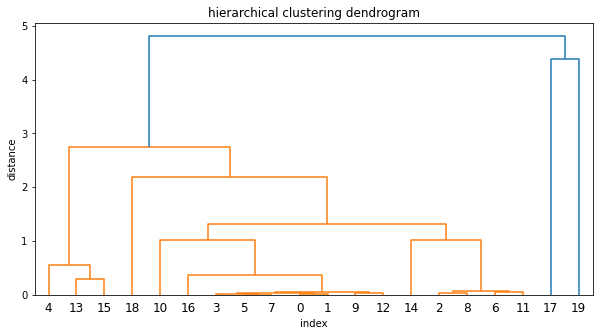

In [1120]:
# now do the clustering
distances = pdist(df2[['MarketCap', 'Volume', 'ProofType']], metric='euclidean')
square_distances = squareform(distances)
# plt.scatter(df2['MarketCap'], df2['Volume'])
condensed_distances = squareform(square_distances)
linkage_matrix = linkage(condensed_distances, method='average')
plt.figure(figsize=(10, 5))
dendrogram(linkage_matrix, labels=df2.index)
plt.xlabel('index')
plt.ylabel('distance')
plt.title('hierarchical clustering dendrogram')
plt.show()

<font color="red">TODO ^ , is it important to use squareform twice ? </font>


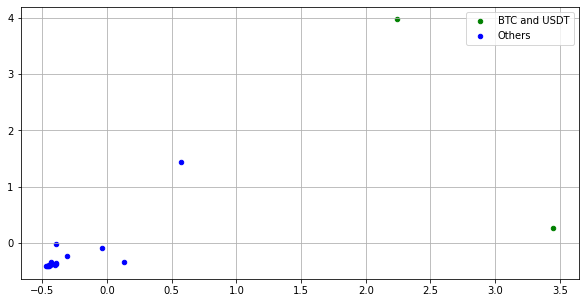

In [1121]:
cluster_assignments = fcluster(linkage_matrix, t=4.5, criterion='distance')
df2['Cluster'] = cluster_assignments
#plot the clusters
plt.figure(figsize=(10, 5))
plt.scatter(df2[df2['Cluster'] == 2]['Volume'], df2[df2['Cluster'] == 2]['MarketCap'], s=20, color='green' , label=df2.iloc[19]['Symbol']+" and "+df2.iloc[17]['Symbol'] )
plt.scatter(df2[df2['Cluster'] == 1]['Volume'], df2[df2['Cluster'] == 1]['MarketCap'], s=20, color='blue' , label='Others')
plt.grid(True)
plt.legend()
df2.drop('Cluster' , axis=1, inplace=True)

## 2-3 : Adding more features to the data

In [1122]:
encoder_n = LabelEncoder()
df2['Network'] = encoder_n.fit_transform(df2['Network'])

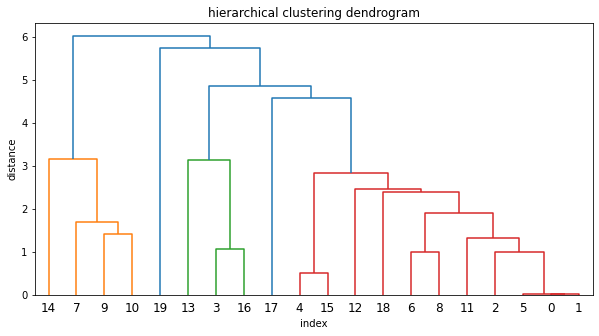

In [1123]:
# now do the clustering
distances = pdist(df2[['MarketCap', 'Volume', 'ProofType' , 'Network']], metric='euclidean')
square_distances = squareform(distances)
# plt.scatter(df2['MarketCap'], df2['Volume'])
condensed_distances = squareform(square_distances)
linkage_matrix = linkage(condensed_distances, method='average')
plt.figure(figsize=(10, 5))
dendrogram(linkage_matrix, labels=df2.index)
plt.xlabel('index')
plt.ylabel('distance')
plt.title('hierarchical clustering dendrogram')
plt.show()

In [1124]:
cluster_assignments = fcluster(linkage_matrix, t=5.8, criterion='distance')
df2['Cluster'] = cluster_assignments

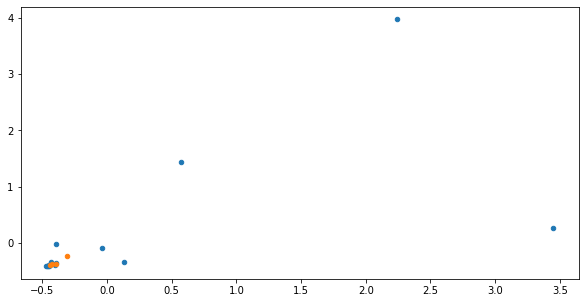

In [1125]:
plt.figure(figsize=(10, 5))
for i in df2['Cluster'].unique():
    plt.scatter(df2[df2['Cluster'] == i]['Volume'], df2[df2['Cluster'] == i]['MarketCap'], s=20, label=i)



<font color="red">TODO ^ </font>


# Part 3

In [838]:
import yfinance as yf
xmr = yf.Ticker("XMR-USD")
df_xmr = yf.download(tickers = "XMR-USD",
                     period = "max",
                     interval = "1d")

[*********************100%%**********************]  1 of 1 completed


Dropping `Afj Close` as it was already in Close column

In [839]:
df_xmr.drop('Adj Close' , axis=1 , inplace=True)

In [840]:
df_xmr

,Open,High,Low,Close,Volume
Date,,,,,
2017-11-09,112.531998,123.404999,112.219002,120.779999,86864600
2017-11-10,121.344002,121.665001,101.757004,105.585999,84614000
2017-11-11,105.750000,127.106003,103.877998,119.615997,107708000
2017-11-12,119.597000,133.675003,110.617996,123.856003,144948000
2017-11-13,128.960007,136.528000,120.921997,123.402000,116200000
...,...,...,...,...,...
2023-10-12,153.852783,154.344238,151.021347,152.341812,65445853
2023-10-13,152.339523,154.368774,151.051971,153.590515,51282283
2023-10-14,153.583801,154.282990,151.850967,152.833160,33344438


## Labling the data

In [841]:
df_xmr['Label'] = (df_xmr['Close'] < df_xmr['Close'].shift(1)).astype(int)

In [843]:
df_xmr[['Close','Label']]

,Close,Label
Date,,
2017-11-09,120.779999,0
2017-11-10,105.585999,1
2017-11-11,119.615997,0
2017-11-12,123.856003,0
2017-11-13,123.402000,1
...,...,...
2023-10-12,152.341812,1
2023-10-13,153.590515,0
2023-10-14,152.833160,1


## Normalization Using StandardScaler

In [844]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df_xmr[['Open','High','Low','Close','Volume']] = scaler.fit_transform(df_xmr[['Open','High','Low','Close','Volume']])

In [845]:
df_xmr[['Close','Volume','Label']]

,Close,Volume,Label
Date,,,
2017-11-09,-0.359156,-0.156407,0
2017-11-10,-0.545721,-0.158662,1
2017-11-11,-0.373448,-0.135522,0
2017-11-12,-0.321386,-0.098207,0
2017-11-13,-0.326960,-0.127013,1
...,...,...,...
2023-10-12,0.028388,-0.177868,1
2023-10-13,0.043720,-0.192060,0
2023-10-14,0.034421,-0.210034,1


<font color="red">TODO ^ OPTIONAL=  MORE FEATURES </font>


## Train,Vaidation,Test Split

In [893]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score , f1_score , classification_report

In [870]:
test_data = df_xmr[(df_xmr.index >= '2023-09-08') & (df_xmr.index <= '2023-10-07')]

In [871]:
# test data is from 08-09-2023 to 07-10-2023 , make it 
test_data = df_xmr[(df_xmr.index >= '2023-09-08') & (df_xmr.index <= '2023-10-07')]
X_test = test_data.drop('Label' , axis=1)
y_test = test_data['Label']
test_data.shape

(30, 6)

In [872]:
df_train = df_xmr.drop(test_data.index , axis=0)

In [875]:
X_train , X_val , y_train , y_val = train_test_split(df_train.drop('Label' , axis=1) , df_train['Label'] , test_size=0.3 , random_state=42)

## Checking if the data is consistent

In [876]:
df_xmr['Label'].value_counts()

0    1136
1    1032
Name: Label, dtype: int64

## Logistic Regression

In [913]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

In [914]:
y_pred = model.predict(X_test)
print(f1_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

0.5882352941176471
              precision    recall  f1-score   support

           0       0.72      1.00      0.84        18
           1       1.00      0.42      0.59        12

    accuracy                           0.77        30
   macro avg       0.86      0.71      0.71        30
weighted avg       0.83      0.77      0.74        30



## Random Forest Classifier

In [915]:
# rf classifier
from sklearn.ensemble import RandomForestClassifier
model_rf = RandomForestClassifier()
model_rf.fit(X_train, y_train)

RandomForestClassifier()

In [916]:
y_pred = model_rf.predict(X_test)
print(f1_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

0.761904761904762
              precision    recall  f1-score   support

           0       0.81      0.94      0.87        18
           1       0.89      0.67      0.76        12

    accuracy                           0.83        30
   macro avg       0.85      0.81      0.82        30
weighted avg       0.84      0.83      0.83        30



## Advanced Methods (Optional) : Neural Network

In [897]:
import tensorflow as tf
recall = tf.keras.metrics.Recall()
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

In [917]:

model_NN = Sequential([
    Dense(64, input_shape=(5,), activation='relu'),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])
model_NN.compile(optimizer='adam', loss='binary_crossentropy', metrics=[recall])
model_NN.fit(X_train, y_train, epochs=50 , validation_data=(X_val, y_val))

Epoch 1/50
47/47 [==============================] - 2s 15ms/step - loss: 0.7049 - recall_7: 0.4931 - val_loss: 0.6840 - val_recall_7: 0.3387
Epoch 2/50
47/47 [==============================] - 0s 4ms/step - loss: 0.6873 - recall_7: 0.2645 - val_loss: 0.6828 - val_recall_7: 0.0000e+00
Epoch 3/50
47/47 [==============================] - 0s 4ms/step - loss: 0.6789 - recall_7: 0.2617 - val_loss: 0.6707 - val_recall_7: 0.4121
Epoch 4/50
47/47 [==============================] - 0s 4ms/step - loss: 0.6709 - recall_7: 0.3465 - val_loss: 0.6619 - val_recall_7: 0.1054
Epoch 5/50
47/47 [==============================] - 0s 4ms/step - loss: 0.6598 - recall_7: 0.4625 - val_loss: 0.6469 - val_recall_7: 0.1821
Epoch 6/50
47/47 [==============================] - 0s 4ms/step - loss: 0.6486 - recall_7: 0.4894 - val_loss: 0.6342 - val_recall_7: 0.3802
Epoch 7/50
47/47 [==============================] - 0s 8ms/step - loss: 0.6244 - recall_7: 0.5615 - val_loss: 0.6160 - val_recall_7: 0.4026
Epoch 8/50
47/4

In [918]:
y_pred_nn = model_NN.predict(X_test)
y_pred_nn = np.round(y_pred_nn)
print(f1_score(y_test, y_pred_nn))

1/1 [==============================] - 0s 133ms/step
0.9090909090909091
